In [5]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import datetime
import glob
import gc
import os
from tqdm import tqdm

#========================================================================
# Args
#========================================================================
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_active_month']

win_path = f'../features/4_winner/*.gz'
fname=''
# submit = pd.read_csv('../input/sample_submission.csv')
submit = []

HOME = os.path.expanduser('~')

sys.path.append(f"{HOME}/kaggle/data_analysis/library/")
import utils
from preprocessing import get_ordinal_mapping, outlier
from utils import logger_func
try:
    if not logger:
        logger=logger_func()
except NameError:
    logger=logger_func()

start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#========================================================================
# Data Load
base = utils.read_df_pkl('../input/base*')
win_path = f'../features/ffm_winner/*.gz'
win_path_list = glob.glob(win_path)
train_path_list = []
test_path_list = []
for path in win_path_list:
    if path.count('train'):
        train_path_list.append(path)
    elif path.count('test'):
        test_path_list.append(path)

# train_path_list = sorted(train_path_list)[:5]
# test_path_list  = sorted(test_path_list)[:5]
        
base_train = base[~base[target].isnull()].reset_index(drop=True)
base_test = base[base[target].isnull()].reset_index(drop=True)
train_feature_list = utils.parallel_load_data(path_list=train_path_list)
test_feature_list = utils.parallel_load_data(path_list=test_path_list)
train = pd.concat(train_feature_list, axis=1)
train = pd.concat([base_train, train], axis=1)
test = pd.concat(test_feature_list, axis=1)
test = pd.concat([base_test, test], axis=1)
train.set_index(key, inplace=True)
test.set_index(key, inplace=True)

train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)

num_list = [col for col in train.columns if (str(train[col].dtype).count('int') or 
                                             str(train[col].dtype).count('float')) and 
            col != target and not(col.count('amount'))]
y = train[target]

train = train[num_list]
test = test[num_list]

# amount_list = [col for col in train.columns if col.count('amount')]
# train[amount_list] = train[amount_list].where(train[amount_list]<2, 2)
# test[amount_list] = test[amount_list].where(train[amount_list]<2, 2)

# arg_list = list(set(num_list) - set(amount_list))

for col in tqdm(num_list):
    train = outlier(df=train, col=col, replace_inner=True)
    test = outlier(df=test, col=col, replace_inner=True)
    
train_test = pd.concat([train[num_list], test[num_list]], axis=0)
scaler = MinMaxScaler()
columns = train_test.columns
train_test = scaler.fit_transform(train_test)
train_test = pd.DataFrame(train_test, columns=columns)
train = train_test.iloc[:len(train), :]
test = train_test.iloc[len(train):, :]
print(train.shape, test.shape)
del train_test
gc.collect()
#========================================================================

100%|██████████| 117/117 [00:41<00:00,  2.74it/s]


(201917, 117) (123623, 117)


76

In [ ]:
import datetime
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
 
# モデルクラス定義
class NN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # クラスの初期化
        # :param input_size: 入力層のサイズ
        # :param hidden_size: 隠れ層のサイズ
        # :param output_size: 出力層のサイズ
        super(NN, self).__init__()
        self.x_layer = torch.nn.Linear(input_size, hidden_size)
        self.h_layer = torch.nn.Linear(hidden_size, hidden_size)
        self.y_layer = torch.nn.Linear(hidden_size, output_size)
 
    def __call__(self, x):
        # 順伝播を計算する関数
        # :param x: 入力値
        h = F.relu(self.x_layer(x))
        h = F.relu(self.h_layer(h))
        y = F.log_softmax(self.y_layer(h))
        return y
# 学習
 
num_epoch = 100
hidden_size = 20
batch_size = 20
 
 # データ
df = load_iris()
N = len(df)
input_size = len(df.columns)
output_size = 1


train_x = np.array(train_x, dtype="float32")
train_y = np.array(train_y, dtype="int32")
test_x = np.array(test_x, dtype="float32")
test_y = np.array(test_y, dtype="int32")
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)
 
# DataLoader化
train = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
 
# モデルの定義
model = NN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
 
# 学習開始
print("Train")
st = datetime.datetime.now()
for epoch in range(num_epoch):
    # ミニバッチ学習
    total_loss = 0
    for i, data in enumerate(train_loader):
        x, y = data
        x, y = Variable(x), Variable(y)
        y = torch.tensor(y, dtype=torch.long)
        optimizer.zero_grad()
        y_ = model(x)
        loss = criterion(y_, y)
        total_loss += loss.data
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        # accuracy
        x, y = Variable(train_x), Variable(train_y)
        _, y_ = torch.max(model(x).data, 1)
        accuracy = sum(y.data.numpy() == y_.numpy()) / N
        # test accuracy
        x, y = Variable(test_x), Variable(test_y)
        _, y_ = torch.max(model(x).data, 1)
        test_accuracy = sum(y.data.numpy() == y_.numpy()) / len(y.data.numpy())
        ed = datetime.datetime.now()
        print("epoch:\t{}\ttotal loss:\t{}\taccuracy:\t{}\tvaridation accuracy\t{}\ttime:\t{}".format(epoch+1, total_loss, accuracy, test_accuracy, ed-st))
        st = datetime.datetime.now()

### Optimizer Check

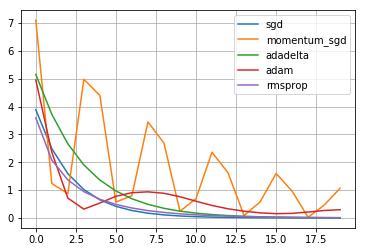

In [5]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))
    
net = Model()
net.to('cuda')

from torch import optim

# 線形レイヤー
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # nn.Linear(input_dim, output_dim)
        self.lin1 = nn.Linear(in_features=10, out_features=10, bias=False)
        
    def forward(self, x):
        x = self.lin1(x)
        return x
    

def main(opt_conf):
    loss_list = []
    # Make Data
    x = torch.randn(1, 10)
    w = torch.randn(1, 1)
    y = torch.mul(w, x) + 2
    
    # Network Definition
    net = Net()
    
    # Loss Function
    criterion = nn.MSELoss()
    
    # 最適化関数
    if opt_conf == 'sgd':
        optimizer = optim.SGD(net.parameters(), lr=0.1)
    elif opt_conf == "momentum_sgd":
        optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    elif opt_conf == "adadelta":
        optimizer = optim.Adadelta(net.parameters(), rho=0.95, eps=1e-04)
    elif opt_conf == "adagrad":
        optimizer = optim.Adagrad(net.parameters())
    elif opt_conf == "adam":
        optimizer = optim.Adam(net.parameters(), lr=1e-1, betas=(0.9, 0.99), eps=1e-09)
    elif opt_conf == "rmsprop":
        optimizer = optim.RMSprop(net.parameters())
        
    # Train
    for epoch in range(20):
        optimizer.zero_grad()
        y_pred = net(x)
        
        loss = criterion(y_pred, y)
        loss.backward()
        
        optimizer.step()
        
        loss_list.append(loss.data.item())
    return loss_list

# Optimize Function
loss_dict = {}
loss_dict["sgd"] = []
loss_dict["momentum_sgd"] = []
loss_dict["adadelta"] = []
loss_dict["adam"] = []
loss_dict["rmsprop"] = []

for key, value in loss_dict.items():
    loss_dict[key] = main(key)
    
from matplotlib import pyplot as plt
plt.figure()
plt.plot(loss_dict["sgd"], label="sgd")
plt.plot(loss_dict["momentum_sgd"], label="momentum_sgd")
plt.plot(loss_dict["adadelta"], label="adadelta")
plt.plot(loss_dict["adam"], label="adam")
plt.plot(loss_dict["rmsprop"], label="rmsprop")
plt.legend() 
plt.grid()
plt.show()

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
train = pd.read_csv("../../house_prise/input/train.csv")
test = pd.read_csv("../../house_prise/input/test.csv")

num_list = [col for col in train.columns if str(train[col].dtype).count('int') or str(train[col].dtype).count('float') ]

train = train[num_list]
num_list.remove('SalePrice')
test = test[num_list]
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

train, valid = train_test_split(train, test_size=0.2)
tmp_y_train = train['SalePrice'].map(lambda x: 1 if x<120000 else 0)
tmp_y_valid = valid['SalePrice'].map(lambda x: 1 if x<120000 else 0)
train.drop('SalePrice', axis=1, inplace=True)
valid.drop('SalePrice', axis=1, inplace=True)

len_train = len(train)
len_valid = len(valid)
len_test = len(test)

train_val = train.values
y_train_val = tmp_y_train.values
valid_val = valid.values
y_valid_val = tmp_y_valid.values
test_val = test.values

x_train = train_val.reshape(len_train, 36)
y_train = y_train_val.reshape(len_train, 1)
x_valid = valid_val.reshape(len_valid, 36)
y_valid = y_valid_val.reshape(len_valid, 1)
x_test = test_val.reshape(len_test, 36)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
# (1168, 36)
# (1168, 1)
# (292, 36)
# (292, 1)

(1168, 36)
(1168, 1)
(292, 36)
(292, 1)


Train
epoch:	10	total loss:	4.84492301940918	accuracy:	0.36	varidation accuracy	0.28	time:	0:00:00.046072
epoch:	20	total loss:	3.8231186866760254	accuracy:	0.66	varidation accuracy	0.68	time:	0:00:00.044013
epoch:	30	total loss:	2.713369607925415	accuracy:	0.69	varidation accuracy	0.68	time:	0:00:00.047219
epoch:	40	total loss:	1.9959430694580078	accuracy:	0.95	varidation accuracy	0.9	time:	0:00:00.047444


/home/ubuntu/anaconda3/envs/nn/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ubuntu/anaconda3/envs/nn/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:	50	total loss:	1.4430568218231201	accuracy:	0.97	varidation accuracy	0.92	time:	0:00:00.048350
epoch:	60	total loss:	1.0565377473831177	accuracy:	0.97	varidation accuracy	0.94	time:	0:00:00.044082
epoch:	70	total loss:	0.805483877658844	accuracy:	0.99	varidation accuracy	0.94	time:	0:00:00.044161
epoch:	80	total loss:	0.6468150019645691	accuracy:	0.99	varidation accuracy	0.94	time:	0:00:00.044075
epoch:	90	total loss:	0.5445878505706787	accuracy:	0.99	varidation accuracy	0.94	time:	0:00:00.044238
epoch:	100	total loss:	0.47537657618522644	accuracy:	0.99	varidation accuracy	0.94	time:	0:00:00.044912
